In [14]:
import pandas as pd
import os, json, sys, subprocess
from numpy import nan
from statistics import median
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

In [2]:
# Results file handling

DATE = "20200423"
RESULTS ="sd2e-project-45/wasserstein-10-fold/{}".format(DATE)
datetime = subprocess.check_output(['date +%Y_%m_%d_%H_%M_%S'],shell=True).decode(sys.stdout.encoding).strip()
base_dir = os.path.join(os.path.expanduser("~"), 'sd2e-projects')
results_dir = os.path.join(base_dir, RESULTS)
results_dir_contents = [os.path.realpath(os.path.join(results_dir, x)) for x in os.listdir(results_dir) if "summary" not in x]
results_dir_short = sorted([r for r in results_dir_contents if "Short" in r])

results_dir_short

['/home/jupyter/sd2e-projects/sd2e-project-45/wasserstein-10-fold/20200423/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-20191208_20200423194115_fc_etl_stats_wasserstein_dists.csv',
 '/home/jupyter/sd2e-projects/sd2e-project-45/wasserstein-10-fold/20200423/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-20191208_20200423194115_fc_raw_log10_stats_wasserstein_dists.csv',
 '/home/jupyter/sd2e-projects/sd2e-project-45/wasserstein-10-fold/20200423/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-35C_20200423195648_fc_etl_stats_wasserstein_dists.csv',
 '/home/jupyter/sd2e-projects/sd2e-project-45/wasserstein-10-fold/20200423/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-35C_20200423195648_fc_raw_log10_stats_wasserstein_dists.csv']

In [3]:
# Metadata file handling

DATA_CONVERGE_PROJECT="sd2e-project-43/test"
exps = [r.split("/") for r in results_dir_short]
experiments = [e.split("_fc")[0] for le in exps for e in le if e.startswith("dc_")]
meta_files = []
for experiment in experiments:
    exp_path = os.path.join(base_dir,DATA_CONVERGE_PROJECT,experiment)
    for fname in os.listdir(exp_path):
        if fname.endswith("_fc_meta.csv"): 
            meta_files.append(os.path.realpath(os.path.join(exp_path,fname)))

meta_files

['/home/jupyter/sd2e-projects/sd2e-project-43/test/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-20191208_20200423194115/YeastSTATES-CRISPR-Short-Duration-Time-Series-20191208__fc_meta.csv',
 '/home/jupyter/sd2e-projects/sd2e-project-43/test/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-20191208_20200423194115/YeastSTATES-CRISPR-Short-Duration-Time-Series-20191208__fc_meta.csv',
 '/home/jupyter/sd2e-projects/sd2e-project-43/test/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-35C_20200423195648/YeastSTATES-CRISPR-Short-Duration-Time-Series-35C__fc_meta.csv',
 '/home/jupyter/sd2e-projects/sd2e-project-43/test/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-35C_20200423195648/YeastSTATES-CRISPR-Short-Duration-Time-Series-35C__fc_meta.csv']

In [4]:
# Helper functions

def load_csv(fname):
    # for both results and combined metadata df
    return pd.read_csv(fname)

def group_me(df,columns):
    # for metadata df
    return df.groupby(columns)

def get_samp_id_order(df):
    # for results df
    return list(df.columns)[1:]

def get_matrix(df):
    #for results df
    return df.values

def get_samp_ids_per_time_point(df,col,value):
    # for group in grouped metadata df
    df2 = df[df[col] == value]
    return df2["sample_id"].values

def get_index_pair_value(results,samp_id_order,id1,id2):
    # for results matrix from results df
    ind1 = samp_id_order.index(id1)
    ind2 = samp_id_order.index(id2)
    return results[ind1,ind2]
    

In [5]:
def compute_time_difference(results_file, metadata_file, columns, comparison_column, comparison_values):
    '''
    results_file = Wasserstein results
    metadata_file = csv with merged metadata columns
    columns = columns to groupby (probably strain, BE conc, and rep)
    comparison_column = column containing the two values to compare
    comparison_values = 2 vector with a start value and an end value
    threshold_10_fold = number above which a minimum of a 10-fold difference is detected (i.e. may want to choose 9.5 instead of 10)
    '''
    meta_df = load_csv(metadata_file)
    meta_grouped = group_me(meta_df,columns)
    res_df = load_csv(results_file)
    samp_id_order = get_samp_id_order(res_df)
    results = get_matrix(res_df)[:,1:]
    values = {}
    missing = []
    for name,group in meta_grouped:
        initial_ids = get_samp_ids_per_time_point(group,comparison_column,comparison_values[0])
        final_ids = get_samp_ids_per_time_point(group,comparison_column,comparison_values[1])
        group_vals = []
        for samp_id_init in initial_ids:
            for samp_id_fin in final_ids:
                try: 
                    val = get_index_pair_value(results,samp_id_order,samp_id_init,samp_id_fin)
                except:
                    # handle dropped samples in ETL
                    # print("One of the two sample ids {} not found.".format([samp_id_init,samp_id_fin]))
                    val = nan                        
                group_vals.append(val)
        if group_vals:
            values[name] = [min(group_vals),median(group_vals),max(group_vals)]
        else:
            missing.append(name)
    summary = pd.DataFrame.from_dict(values, orient='index',columns=['wasserstein_min','wasserstein_median','wasserstein_max'])
    return summary,missing
        
                

In [29]:
def save_summary(summary,fname):
    summary.to_csv(fname)
    
def save_params(params,fname):
    json.dump(params,open(fname,"w"))
    
def compute_summary(results_dir_contents, meta_files, groupby_columns, comparison_column, comparison_values,identifier = "_time_diff_"):
    all_summaries = {}
    for results_file,metadata_file in zip(results_dir_contents,meta_files):
        summary,_ = compute_time_difference(results_file, metadata_file, groupby_columns, comparison_column, comparison_values)
        #fname = results_file.split(".")[0] + identifier + "summary_" + datetime + ".csv"
        fname = results_file.split("/")[-1].split(".")[0] + identifier + "summary_" + datetime + ".csv"
        save_summary(summary,fname)
        params = {"results_file" : results_file, "metadata_file" : metadata_file, "groupby_columns" : groupby_columns, "comparison_column" : comparison_column,  "comparison_values" : comparison_values }
        #fname = results_file.split(".")[0] + identifier + "params_" + datetime + ".csv"
        fname = results_file.split("/")[-1].split(".")[0] + identifier + "params_" + datetime + ".csv"
        save_params(params,fname)
        all_summaries[results_file] = summary
    return all_summaries
        
        
def plot_above_threshold(all_summaries,thresholds = [x/2 for x in range(0,21)],column="wasserstein_median"):
    for results_file, summary in all_summaries.items():
        norm_cst = len(summary.index)
        plt.figure()
        tag = " (ETL)" if "fc_etl" in results_file else " (log10)"
        plt.title(results_file.split("/")[-1].split(".")[0].split("20")[0][:-1] + tag,fontsize=12)
        y = []
        for t in thresholds:
            y.append(len(summary[summary[column] >= t].index)/norm_cst)
        plt.xlabel("Fold change")
        plt.ylabel("Percentage of samples")
        plt.ylim([0.0,1.0])
        plt.plot(thresholds,y,linewidth=2)
        plt.tight_layout()
        plt.savefig(results_file.split("/")[-1].split(".")[0]+".png",dpi=300)
        plt.show()
            
            

    

In [7]:
all_summaries = compute_summary(results_dir_short, meta_files, ["strain","inducer_concentration"], "timepoint", [18.0,24.0])


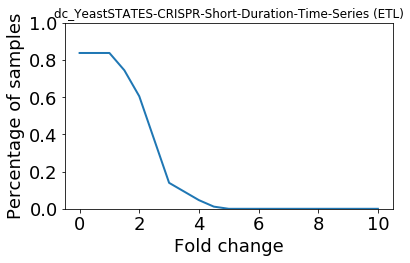

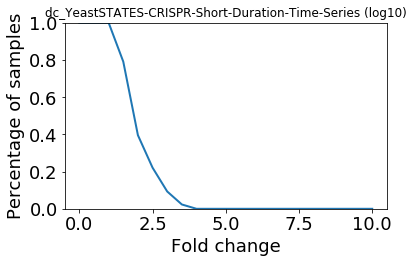

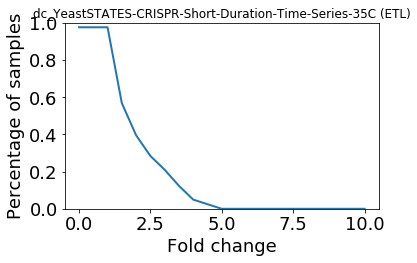

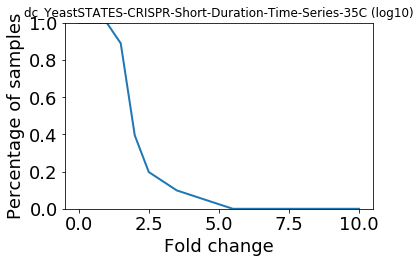

In [30]:
plot_above_threshold(all_summaries)


In [9]:
for r,s in all_summaries.items():
    print(r)
    print(len(s.index))

/home/jupyter/sd2e-projects/sd2e-project-45/wasserstein-10-fold/20200423/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-20191208_20200423194115_fc_etl_stats_wasserstein_dists.csv
86
/home/jupyter/sd2e-projects/sd2e-project-45/wasserstein-10-fold/20200423/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-20191208_20200423194115_fc_raw_log10_stats_wasserstein_dists.csv
86
/home/jupyter/sd2e-projects/sd2e-project-45/wasserstein-10-fold/20200423/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-35C_20200423195648_fc_etl_stats_wasserstein_dists.csv
81
/home/jupyter/sd2e-projects/sd2e-project-45/wasserstein-10-fold/20200423/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-35C_20200423195648_fc_raw_log10_stats_wasserstein_dists.csv
81
